In [10]:
# 1) 한글 폰트 설치
!apt-get -y install fonts-nanum fonts-noto-cjk > /dev/null

# 2) 매트플롯립에 폰트 등록 및 기본 폰트 지정
import matplotlib as mpl
from matplotlib import font_manager as fm
import glob, os

# 설치된 나눔/노토 폰트 경로 자동 탐색 후 등록
font_paths = []
font_paths += glob.glob("/usr/share/fonts/truetype/nanum/*.ttf")
font_paths += glob.glob("/usr/share/fonts/opentype/noto/*CJK*.otf")
font_paths += glob.glob("/usr/share/fonts/opentype/noto/*CJK*.ttc")

for p in font_paths:
    try:
        fm.fontManager.addfont(p)
    except Exception:
        pass

# 3) 기본 폰트 패밀리 지정(우선순위)
mpl.rcParams["font.family"] = ["NanumGothic", "Noto Sans CJK KR", "AppleGothic", "Malgun Gothic", "DejaVu Sans"]
mpl.rcParams["axes.unicode_minus"] = False

# 4) 폰트 캐시 재로딩(중요)
try:
    fm._load_fontmanager(try_read_cache=False)  # Matplotlib >=3.6 권장
except Exception:
    fm._rebuild()  # 구버전 대응

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

DATE_COL_PATTERN = re.compile(r'^\s*\d{4}\.(?:0?[1-9]|1[0-2])\s*$')

def to_month_end_datetime(s):
    s = str(s).strip()
    s = re.sub(r'\s*p\)\s*$', '', s)   # ' p)' 제거
    dt = pd.to_datetime(s, format='%Y.%m', errors='coerce')
    if pd.isna(dt):
        return pd.NaT
    return pd.Period(dt, freq='M').to_timestamp(how='end')

def detect_date_columns(df):
    return [c for c in df.columns if DATE_COL_PATTERN.match(str(c))]

def melt_wide_monthly(df, id_col=None):
    date_cols = detect_date_columns(df)
    if not date_cols:
        return None
    id_vars = [id_col] if (id_col is not None and id_col in df.columns) else []
    long_df = df.melt(id_vars=id_vars, value_vars=date_cols,
                      var_name='DateStr', value_name='Value')
    long_df['Date'] = long_df['DateStr'].apply(to_month_end_datetime)
    long_df = long_df[['Date','Value']].dropna().sort_values('Date')
    return long_df

def load_series_auto(csv_path, preferred_label_col=None, preferred_label_value=None):
    last_err = None
    for enc in ['utf-8-sig','cp949','euc-kr','utf-8']:
        try:
            df = pd.read_csv(csv_path, encoding=enc)
            break
        except Exception as e:
            last_err = e
            df = None
    if df is None:
        raise RuntimeError(f"CSV 읽기 실패: {last_err}")

    if preferred_label_col and preferred_label_col in df.columns and preferred_label_value is not None:
        df = df[df[preferred_label_col].astype(str).str.strip() == str(preferred_label_value).strip()]

    long_df = melt_wide_monthly(df, id_col=preferred_label_col if (df is not None and preferred_label_col in df.columns) else None)
    if long_df is not None and not long_df.empty:
        s = pd.Series(long_df['Value'].astype(float).values, index=long_df['Date'].values)
        s = s[~s.index.duplicated(keep='last')].sort_index()
        return s

    date_candidates = [c for c in df.columns if str(c).strip() in ['Date','날짜','기간','기준월','월']]
    val_candidates  = [c for c in df.columns if str(c).strip() in ['Value','값','지수','지표값','Index','IndexValue','값(지수)']]
    if not val_candidates:
        numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        if len(numeric_cols) == 1:
            val_candidates = numeric_cols

    if date_candidates and val_candidates:
        dcol, vcol = date_candidates[0], val_candidates[0]
        tmp = df[[dcol, vcol]].copy()
        tmp['Date'] = tmp[dcol].apply(lambda x: to_month_end_datetime(x) if pd.notna(x) else pd.NaT)
        tmp = tmp[['Date', vcol]].dropna().rename(columns={vcol:'Value'})
        s = pd.Series(tmp['Value'].astype(float).values, index=tmp['Date'].values)
        s = s[~s.index.duplicated(keep='last')].sort_index()
        return s

    raise ValueError(f"형식 자동 인식 실패. 열 목록: {list(df.columns)}")

def bk_cycle(series_log, low=18, high=96, K=12):
    cyc = sm.tsa.filters.bkfilter(series_log.dropna(), low=low, high=96, K=K)
    cyc.name = 'cycle'
    return cyc

def zscore_over_overlap(s1, s2):
    common_idx = s1.index.intersection(s2.index)
    a = s1.loc[common_idx]
    b = s2.loc[common_idx]
    az = (a - a.mean()) / a.std(ddof=0)
    bz = (b - b.mean()) / b.std(ddof=0)
    return az, bz

def normalize_base100_over_overlap(level1, level2):
    common_idx = level1.index.intersection(level2.index)
    a = level1.loc[common_idx].astype(float)
    b = level2.loc[common_idx].astype(float)
    a_norm = a / a.iloc[0] * 100.0
    b_norm = b / b.iloc[0] * 100.0
    return a_norm, b_norm

In [3]:
from google.colab import files
uploaded = files.upload()
list(uploaded.keys())

Saving durables.csv to durables.csv
Saving ip_index.csv to ip_index.csv


['durables.csv', 'ip_index.csv']

In [8]:
# 업로드한 실제 파일명을 변수에 할당
durables_csv = 'durables.csv'
ip_csv       = 'ip_index.csv'

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# YYYY-MM 형태
DATE_RE_DASH = re.compile(r'^\s*\d{4}-(?:0[1-9]|1[0-2])\s*$')
# YYYY.MM 형태
DATE_RE_DOT  = re.compile(r'^\s*\d{4}\.(?:0?[1-9]|1[0-2])\s*$')

def to_month_end_datetime_dash(s):
    s = str(s).strip()
    dt = pd.to_datetime(s, format='%Y-%m', errors='coerce')
    if pd.isna(dt):
        return pd.NaT
    return pd.Period(dt, freq='M').to_timestamp(how='end')

def to_month_end_datetime_dot(s):
    s = str(s).strip()
    s = re.sub(r'\s*p\)\s*$', '', s)  # ' p)' 제거
    dt = pd.to_datetime(s, format='%Y.%m', errors='coerce')
    if pd.isna(dt):
        return pd.NaT
    return pd.Period(dt, freq='M').to_timestamp(how='end')

def load_ip_from_wide(csv_path):
    # 전산업생산지수: wide(YYYY.MM 열들) + '산업별 지수' 행 필터
    last_err = None
    for enc in ['utf-8-sig','cp949','euc-kr','utf-8']:
        try:
            df = pd.read_csv(csv_path, encoding=enc)
            break
        except Exception as e:
            last_err = e
            df = None
    if df is None:
        raise RuntimeError(f"ip csv 읽기 실패: {last_err}")

    df = df[df['산업별 지수'].astype(str).str.strip() == '전산업생산지수']
    # 날짜열(YYYY.MM)만 추출
    date_cols = [c for c in df.columns if DATE_RE_DOT.match(str(c))]
    if not date_cols:
        raise ValueError("전산업생산지수 CSV에서 YYYY.MM 형태의 날짜 열을 찾지 못함.")
    long_df = df.melt(id_vars=['산업별 지수'], value_vars=date_cols, var_name='DateStr', value_name='Value')
    long_df['Date'] = long_df['DateStr'].apply(to_month_end_datetime_dot)
    long_df = long_df[['Date','Value']].dropna().sort_values('Date')
    s = pd.Series(pd.to_numeric(long_df['Value'], errors='coerce').values, index=long_df['Date'].values)
    s = s.dropna()
    return s[~s.index.duplicated(keep='last')].sort_index()

def load_durables_from_kosis(csv_path):
    """
    스크린샷 구조 대응:
    - 상단 메타 행들(주석/출처/범례명/단위/주기/기간 …)
    - 그 다음부터 첫 열에 YYYY-MM, 두 번째 열에 지수(괄호: S.A., 2020=100), 세 번째 열에 전년동월비(%)
    """
    last_err = None
    for enc in ['utf-8-sig','cp949','euc-kr','utf-8']:
        try:
            raw = pd.read_csv(csv_path, encoding=enc, header=None)
            break
        except Exception as e:
            last_err = e
            raw = None
    if raw is None:
        raise RuntimeError(f"durables csv 읽기 실패: {last_err}")

    # 첫 열에서 YYYY-MM 시작 지점 찾기
    first_col = raw.iloc[:, 0].astype(str)
    start_idx = None
    for i, v in enumerate(first_col):
        if DATE_RE_DASH.match(v):
            start_idx = i
            break
    if start_idx is None:
        raise ValueError("durables CSV에서 YYYY-MM 형태의 시작 행을 찾지 못함.")

    data = raw.iloc[start_idx:, :3].copy()
    data.columns = ['Period', 'Index', 'YoY']
    # 날짜 파싱
    data['Date'] = data['Period'].apply(to_month_end_datetime_dash)
    # 값 파싱(숫자만)
    data['Index'] = pd.to_numeric(data['Index'], errors='coerce')
    # 필요 시 전년동월비도 숫자로
    data['YoY']   = pd.to_numeric(data['YoY'], errors='coerce')

    out = data[['Date','Index']].dropna().sort_values('Date')
    s = pd.Series(out['Index'].values, index=out['Date'].values)
    s = s.dropna()
    return s[~s.index.duplicated(keep='last')].sort_index()

# 1) 전산업생산지수(로그/월말) 시리즈
ip_level = load_ip_from_wide(ip_csv)

# 2) 내구재 판매액지수(로그/월말) 시리즈
durables_level = load_durables_from_kosis(durables_csv)

# 3) 범위 정보 출력
def span(s):
    return s.index.min().date(), s.index.max().date(), s.shape[0]
print("전산업생산지수 범위:", span(ip_level))
print("내구재판매액지수 범위:", span(durables_level))

# 4) 로그
ip_log        = np.log(ip_level.astype(float))
durables_log  = np.log(durables_level.astype(float))

# 5) BK 필터(18~96개월, K=12)
ip_cycle        = sm.tsa.filters.bkfilter(ip_log.dropna(),       low=18, high=96, K=12)
durables_cycle  = sm.tsa.filters.bkfilter(durables_log.dropna(), low=18, high=96, K=12)

# 6) 공통 구간
common_idx = ip_cycle.dropna().index.intersection(durables_cycle.dropna().index)
print("공통 구간:", common_idx.min().date(), "→", common_idx.max().date(), f"({len(common_idx)}개월)")

전산업생산지수 범위: (datetime.date(2000, 1, 31), datetime.date(2025, 4, 30), 304)
내구재판매액지수 범위: (datetime.date(1995, 1, 31), datetime.date(2025, 6, 30), 366)
공통 구간: 2001-01-31 → 2024-04-30 (280개월)


겹치는 기간 z-score 상관계수: 0.563
최고 교차상관: lag=1개월, corr=0.592
해석: durables가 약 1 개월 선행.


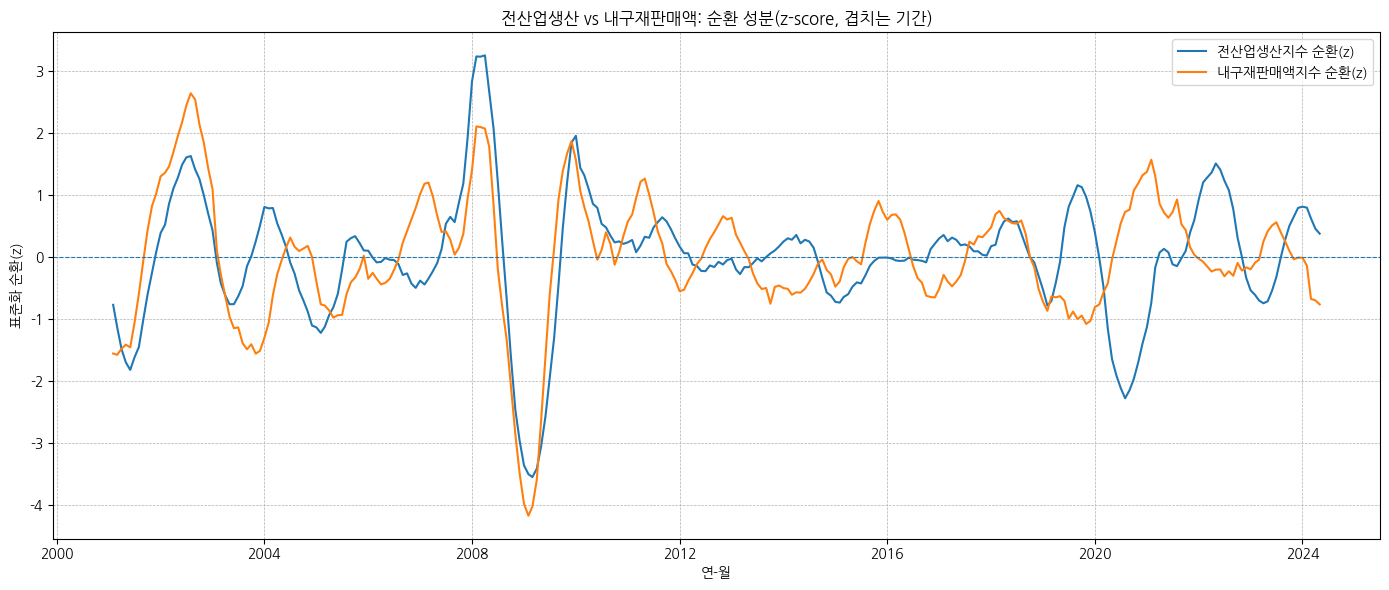

In [11]:
# 겹치는 기간에서 z-score 표준화
def zscore_over_overlap(s1, s2):
    common_idx = s1.index.intersection(s2.index)
    a = s1.loc[common_idx]
    b = s2.loc[common_idx]
    az = (a - a.mean()) / a.std(ddof=0)
    bz = (b - b.mean()) / b.std(ddof=0)
    return az, bz

ip_z, durables_z = zscore_over_overlap(ip_cycle.dropna(), durables_cycle.dropna())

# 상관계수
pearson_r = ip_z.corr(durables_z)
print("겹치는 기간 z-score 상관계수:", round(float(pearson_r), 3))

# 간단 교차상관으로 리드/래그(±12개월) 탐색
def best_lag(a, b, max_lag=12):
    best = (0, a.corr(b))
    for lag in range(-max_lag, max_lag+1):
        if lag == 0:
            continue
        corr = a.corr(b.shift(lag))
        if pd.notna(corr) and corr > best[1]:
            best = (lag, corr)
    return best

lag, lag_corr = best_lag(ip_z, durables_z, max_lag=12)
print(f"최고 교차상관: lag={lag}개월, corr={round(float(lag_corr),3)}")
if lag > 0:
    print("해석: durables가 약", lag, "개월 선행.")
elif lag < 0:
    print("해석: 전산업생산지수가 약", abs(lag), "개월 선행.")
else:
    print("해석: 유의미한 선행·후행이 크지 않음.")

# 시각화
plt.figure(figsize=(14,6))
plt.plot(ip_z.index, ip_z.values, label='전산업생산지수 순환(z)')
plt.plot(durables_z.index, durables_z.values, label='내구재판매액지수 순환(z)')
plt.axhline(0, linestyle='--', linewidth=0.8)
plt.title('전산업생산 vs 내구재판매액: 순환 성분(z-score, 겹치는 기간)')
plt.xlabel('연-월'); plt.ylabel('표준화 순환(z)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

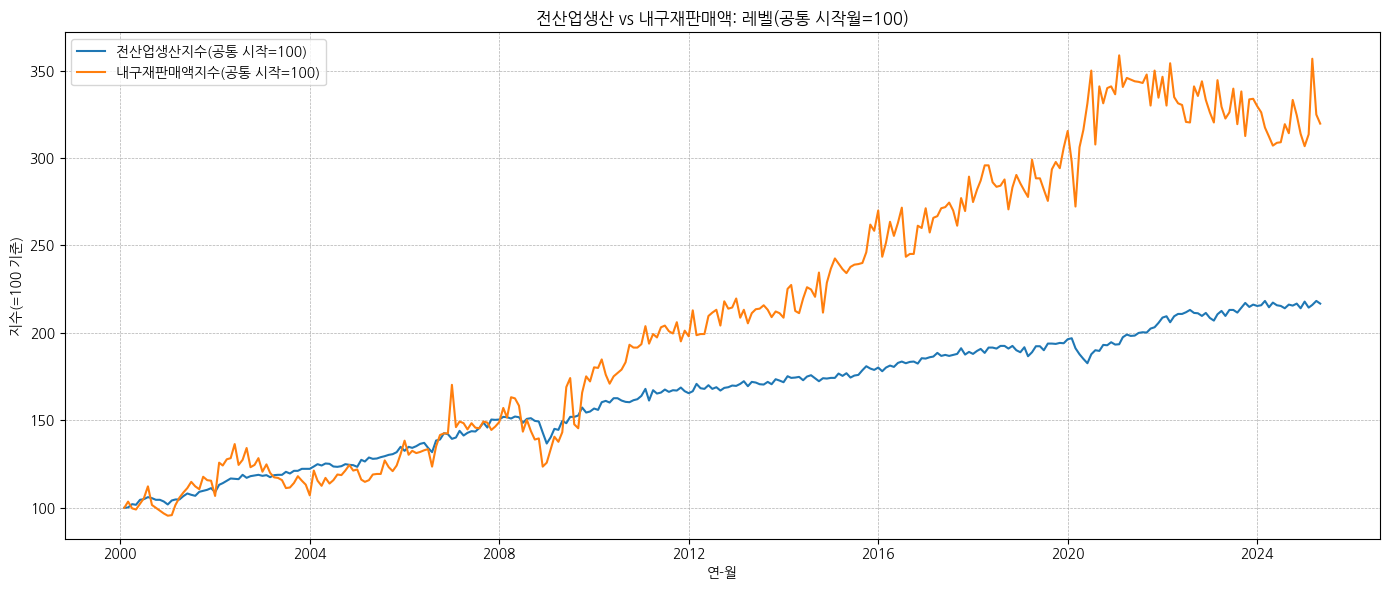

In [12]:
def normalize_base100_over_overlap(level1, level2):
    common_idx = level1.index.intersection(level2.index)
    a = level1.loc[common_idx].astype(float)
    b = level2.loc[common_idx].astype(float)
    a_norm = a / a.iloc[0] * 100.0
    b_norm = b / b.iloc[0] * 100.0
    return a_norm, b_norm

ip_norm, durables_norm = normalize_base100_over_overlap(ip_level, durables_level)

plt.figure(figsize=(14,6))
plt.plot(ip_norm.index, ip_norm.values, label='전산업생산지수(공통 시작=100)')
plt.plot(durables_norm.index, durables_norm.values, label='내구재판매액지수(공통 시작=100)')
plt.title('전산업생산 vs 내구재판매액: 레벨(공통 시작월=100)')
plt.xlabel('연-월'); plt.ylabel('지수(=100 기준)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

저장 완료: cycle_compare_z.png, cycles_raw.csv, cycles_overlap_z.csv


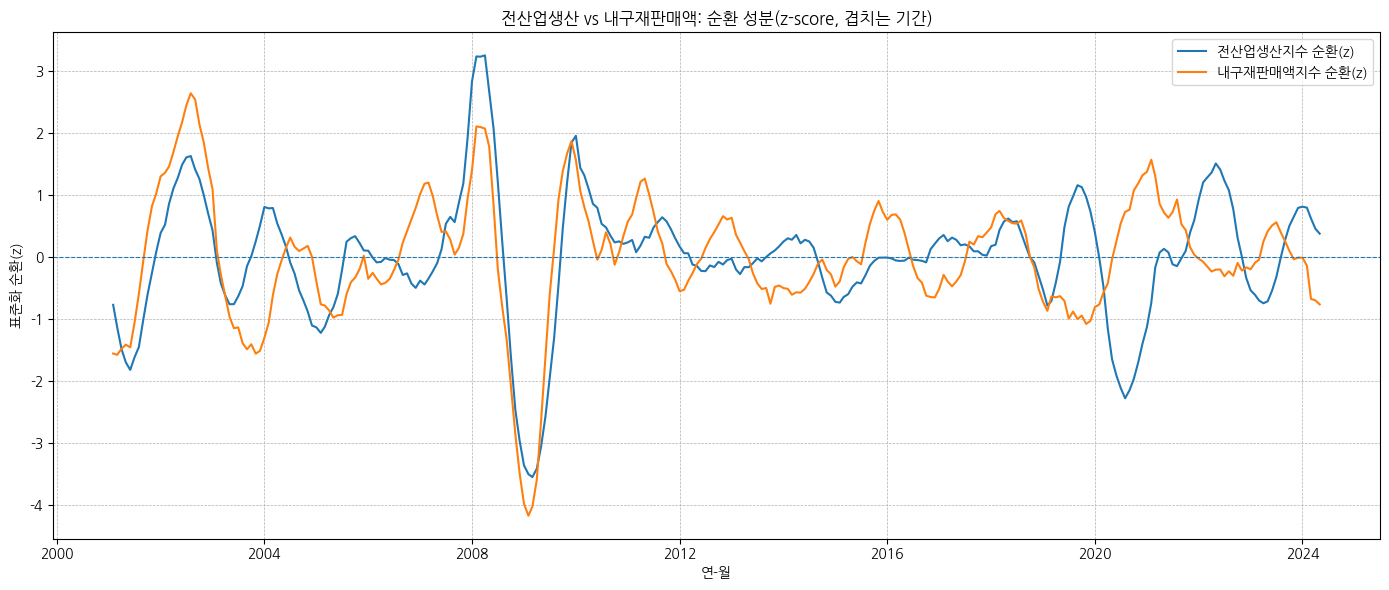

In [13]:
# z-score 비교 그래프 저장
plt.figure(figsize=(14,6))
plt.plot(ip_z.index, ip_z.values, label='전산업생산지수 순환(z)')
plt.plot(durables_z.index, durables_z.values, label='내구재판매액지수 순환(z)')
plt.axhline(0, linestyle='--', linewidth=0.8)
plt.title('전산업생산 vs 내구재판매액: 순환 성분(z-score, 겹치는 기간)')
plt.xlabel('연-월'); plt.ylabel('표준화 순환(z)')
plt.grid(True, linestyle='--', linewidth=0.5); plt.legend(); plt.tight_layout()
plt.savefig('cycle_compare_z.png', dpi=150)

# 순환 성분과 겹치는 z-score 데이터 저장
out = pd.DataFrame({'IP_cycle': ip_cycle, 'Durables_cycle': durables_cycle}).dropna()
out.to_csv('cycles_raw.csv', encoding='utf-8-sig')

overlap_df = pd.DataFrame({'IP_cycle_z': ip_z, 'Durables_cycle_z': durables_z})
overlap_df.to_csv('cycles_overlap_z.csv', encoding='utf-8-sig')

print("저장 완료: cycle_compare_z.png, cycles_raw.csv, cycles_overlap_z.csv")

In [14]:
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import numpy as np

# 공통 구간 맞추기
common_idx = ip_cycle.dropna().index.intersection(durables_cycle.dropna().index)
ip_c = ip_cycle.loc[common_idx]
durables_c = durables_cycle.loc[common_idx]

# 단순 선형회귀: durables_c ~ ip_c
X = sm.add_constant(ip_c.values)  # 상수항 포함
y = durables_c.values
model = sm.OLS(y, X).fit()

# 회귀 결과
print(model.summary())

# R^2 값
r2 = model.rsquared
print("R²:", round(r2, 3))

# RMSE 값
y_pred = model.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("RMSE:", round(rmse, 3))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     129.3
Date:                Mon, 18 Aug 2025   Prob (F-statistic):           7.34e-25
Time:                        08:47:31   Log-Likelihood:                 715.85
No. Observations:                 280   AIC:                            -1428.
Df Residuals:                     278   BIC:                            -1420.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.347      0.7